# Effect of Different Block Sizes on Access Speed with Zstd and SquashFS

### Notebook Configurations

_Imports_

In [1]:
import os
import time 
import random
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_Matplotlib Figures Styles_

In [2]:
plt.rcParams['figure.figsize'] = (10, 7) # for the size of matplotlib plots
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = "y"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['grid.color'] = "#EEEEEE"

### Initial Hyphotesis

Small block sizes in compression can result in faster random reads, in this case, in a mounted SquashFS image.

### Initial variables

In the use case of a read-only filesystem (such as SquashFS), the decompression latency is a lot more important than compression latency. Thus, a high compression level for Zstd, which envolves slower compression speed but higher ratios and faster decompression, is optimal. 

* __Zstd compression level:__ 19

In [3]:
compression_level = 19 # high compression level for Zstandard (max is 22)

For this tests, the next files are used:

* __enwik9__: database based on Wikipedia composed of mostly english text in XML encoded with UTF-8. _Total size of file:_ 1GB

In [4]:
file = "enwik9"

For reproducible results, use __42__ as random seed.

In [5]:
random.seed(42)

_Helper functions_

In [6]:
def get_file_size(file):
    
    is_directory = os.popen(f"./is_directory.sh {file}").read().strip() # shell script to check if string corresponds to dir or file
    
    if(is_directory == "1"):
        size = os.popen(f"du -b {file}").read().split("\t")[0]
    else:
        size = os.popen(f"ls -l {file}").read().split(" ")[4]
    
    return int(size)


def get_speed(size, time):
    
    size_in_mb = size / (1024*1024)
    
    return round((size_in_mb/time), 2)


def get_compression_ratio(original, new):
    return original / new


## Effect of block sizes on Access Speed with Zstd and SquashFS

In summary, for each of the 5 block sizes a new SquashFS image is created from the enwik9 file. This image is then mounted in the _/mnt/squashfs-practice mountpoint_ from where it will be randomly accessed a N times. 

The following script calculates the time that it takes to complete the N lookups and stores the results in a Pandas DataFrame.

__Example Compression:__ _mksquashfs FILE FILE.sqsh -comp zstd -Xcompression-level 19 -b BLOCKSIZE_

In [10]:
password = getpass.getpass() # Root user is needed to perform mounting/unmounting

block_sizes = ["4K", "16K", "64K", "256K", "1M"] # different block sizes, powers of 4
NB_LOOKUPS = 10000 # Number of random accesses to the file

df_19 = pd.DataFrame() # new DataFrame to store the data

print(f"--| RANDOM ACCESS TO {file} |--")
 
size_original = get_file_size(file)
filename = file.split(".")[0] # in case file has file format extension

for i in range(10):
    positions = random.sample(range(0, size_original), NB_LOOKUPS) # sample of NB_LOOKUPS random integers
    print(f"Total positions for lookup: {len(positions)}")

    for size in block_sizes:

        # -- COMPRESSION PROCESS -- #
        new_file = f"{filename}-{size}"

        compression_command = f"mksquashfs {file} {new_file}.sqsh -comp zstd -Xcompression-level {compression_level} -b {size} > /dev/null"

        # Compress and calculate time
        start_time = time.time()
        os.system(compression_command)
        compression_time = time.time() - start_time

        size_new = get_file_size(f"{new_file}.sqsh")

        # Calc metrics
        compression_ratio = get_compression_ratio(size_original, size_new)
        compression_speed = get_speed(size_original, compression_time)

        # -- MOUNTING PROCESS -- #
        mounting_command = f"sudo -S mount {new_file}.sqsh /mnt/squashfs-practice/ -t squashfs -o loop"
        os.system("echo %s | %s" % (password, mounting_command))

        # -- RANDOM ACCESS PATTERN -- #
        fhand = open(f"/mnt/squashfs-practice/{filename}", "rb") # file object read as binary

        start_time = time.time()

        acc = 0
        for pos in positions:
            fhand.seek(pos)
            val = ord(fhand.read(1)) # convert char to ASCII int
            acc += val

        access_time = time.time() - start_time

        print(f"Total sum (block size -> {size}): {acc}")

        os.system("sync") # flush cache to reaload after each mount


        # -- RESULTS SAVING -- #

        df_19 = df_19.append({
            "block_size": size,
            f"compression_ratio": compression_ratio,
            f"compression_speed": compression_speed,
            f"access_time": access_time
        }, ignore_index=True)

        # -- UNMOUNTING PROCESS -- #
        unmounting_command = f"sudo -S umount -l /mnt/squashfs-practice/"
        os.system(f"echo {password} | {unmounting_command}")

    os.system(f"ls | grep {filename}- | xargs rm -R") # Code to remove the created files 

········
--| RANDOM ACCESS TO enwik9 |--
Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 880995


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 880995


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 880995


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 880995


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 880995


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 881627


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 881627


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 881627


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 881627


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 881627


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 882095


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 882095


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 882095


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 882095


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 882095


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 873333


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 873333


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 873333


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 873333


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 873333


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 882099


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 882099


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 882099


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 882099


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 882099


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 883800


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 883800


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 883800


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 883800


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 883800


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 881567


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 881567


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 881567


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 881567


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 881567


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 880210


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 880210


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 880210


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 880210


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 880210


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 884684


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 884684


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 884684


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 884684


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 884684


[sudo] password for carloscrg19: 

Total positions for lookup: 10000


[sudo] password for carloscrg19: 

Total sum (block size -> 4K): 876424


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 16K): 876424


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 64K): 876424


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 256K): 876424


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Total sum (block size -> 1M): 876424


[sudo] password for carloscrg19: 

### Results

The obtained data stored in the main DataFrame.

In [11]:
df_19

,block_size,compression_ratio,compression_speed,access_time
0,4K,2.255570,52.23,1.086546
1,16K,2.734336,36.13,1.211001
2,64K,3.103864,24.11,1.474247
3,256K,3.401803,22.57,2.080417
4,1M,3.673055,20.57,2.288074
5,4K,2.255570,43.13,1.134752
6,16K,2.734336,32.59,1.139660
7,64K,3.103864,23.25,1.399750
8,256K,3.401803,21.85,2.105267
9,1M,3.673055,18.98,2.345601


Access Time Results for every Block Size.

In [42]:
print("Average results for Acess Time")

mean_df = df_19.groupby("block_size").access_time.agg(["min", "max", "mean", "std"])

# Sorting the DataFrame on Block Size
mean_df["sort"] = mean_df.index.map(lambda x: int(x[:-1]) if x[-1] == "K" else int(x[:-1])*1000)
mean_df.sort_values(by="sort", inplace=True)
mean_df.drop("sort", axis=1, inplace=True)

mean_df

Average results for Acess Time


,min,max,mean,std
block_size,,,,
4K,1.049045,1.204005,1.105228,0.044999
16K,1.139660,1.270790,1.179406,0.047294
64K,1.373199,1.483376,1.421413,0.036549
256K,2.080417,2.305639,2.203323,0.077880
1M,2.031581,2.345601,2.166332,0.113769


Creation of main graph. 

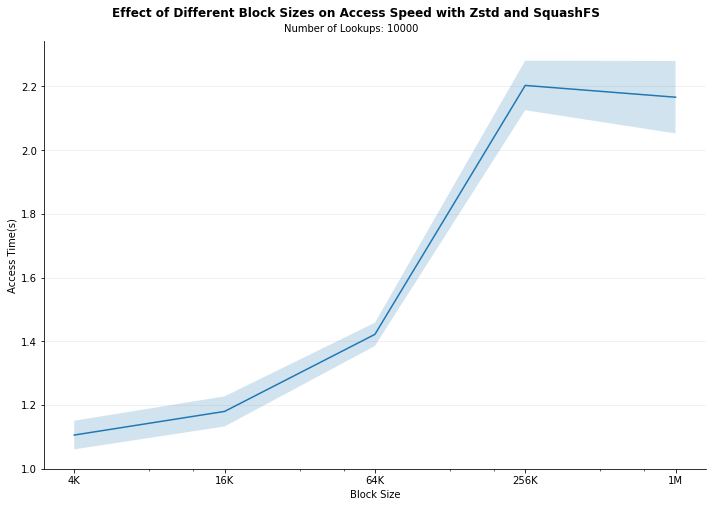

In [54]:
fig, ax = plt.subplots()

fig.suptitle("Effect of Different Block Sizes on Access Speed with Zstd and SquashFS", weight="bold", y=1)
fig.text(s=f"Number of Lookups: {NB_LOOKUPS}", y=0.95, x=0.4)

x = [pow(4,i) for i in range(1, 6)] # Array for ticks in X axis 

ax.semilogx(x, mean_df["mean"], base=4)
ax.fill_between(x, mean_df["mean"] - mean_df["std"], mean_df["mean"] + mean_df["std"], alpha=0.2)

ax.set_ylabel("Access Time(s)")
ax.set_xlabel("Block Size")
ax.set_xticks(x)
ax.set_xticklabels(block_sizes)

fig.tight_layout()
plt.show()